INTERFERENCE SYSTEM I - pm10, pm2.5 -> pollution

In [1497]:
# assessment data:
# https://www.eea.europa.eu/publications/status-of-air-quality-in-Europe-2022/europes-air-quality-status-2022/world-health-organization-who-air
# https://powietrze.gios.gov.pl/pjp/content/annual_assessment_air_acceptable_level

# *data:
# https://powietrze.gios.gov.pl/pjp/current/station_details/archive/402
# http://meteo.kdwd.webd.pl/wxhistory.php?date=202310
# * in exported csv, CO values are in mg/m3 not ug/m3

In [1498]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skfuzzy import control as ctrl

In [1499]:
pm10_safe_limit = 50 # 1h -> ug/m3
pm25_safe_limit = 25 # 1h -> ug/m3

In [1500]:
column_names = ["Date Time", "PM10", "PM25"]
df = pd.read_csv("gios-pjp-data.csv", sep=",", skiprows=1, header=None)
df = df.iloc[:, :-4]
df.columns = column_names
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%Y-%m-%d %H:%M")
df["PM10"] = df["PM10"].astype(float)
df["PM25"] = df["PM25"].astype(float)
df = df.drop(df.tail(1).index)
df.head()

,Date Time,PM10,PM25
0,2023-10-01 01:00:00,18.9,25.8
1,2023-10-01 02:00:00,18.9,25.2
2,2023-10-01 03:00:00,19.2,25.3
3,2023-10-01 04:00:00,21.9,28.5
4,2023-10-01 05:00:00,21.0,25.5


In [1501]:
column_names_wind = ["Date", "Wind"]
df_wind = pd.read_csv("wind.csv", sep=",", header=None)
df_wind = df_wind.iloc[:, :-1]
df_wind.columns = column_names_wind
df_wind["Date"] = pd.to_datetime(df_wind["Date"], format="%d.%m.%Y")
df_wind["Wind"] = df_wind["Wind"].astype(float)
df_wind.head()

,Date,Wind
0,2023-10-01,1.2
1,2023-10-02,1.5
2,2023-10-03,2.8
3,2024-10-04,4.5
4,2024-10-05,3.1


In [1502]:
dataframes = []

for index, row in df_wind.iterrows():
    for hour in range(24):
        new_date_time = row["Date"] + pd.DateOffset(hours=hour)
        dataframes.append(pd.DataFrame({"Date Time": [new_date_time], "Wind": [row["Wind"]]}))

df_hourly_wind = pd.concat(dataframes)

column_hourly_wind = ["Date Time", "Wind"]
df_hourly_wind.columns = column_hourly_wind

df_hourly_wind["Date Time"] = pd.to_datetime(df_hourly_wind["Date Time"], format="%Y-%m-%d %H:%M")
df_hourly_wind["Wind"] = df_hourly_wind["Wind"].astype(float)

df_hourly_wind = df_hourly_wind.reset_index(drop=True)
df_hourly_wind.head()

,Date Time,Wind
0,2023-10-01 00:00:00,1.2
1,2023-10-01 01:00:00,1.2
2,2023-10-01 02:00:00,1.2
3,2023-10-01 03:00:00,1.2
4,2023-10-01 04:00:00,1.2


In [1503]:
df = df.join(df_hourly_wind, lsuffix="_df", rsuffix="_df_hourly_wind")
df.drop("Date Time_df_hourly_wind", axis=1, inplace=True)
df.describe()

,Date Time_df,PM10,PM25,Wind
count,743,743.000000,743.000000,743.000000
mean,2023-10-16 12:00:00.000000256,18.842665,27.137550,2.992598
min,2023-10-01 01:00:00,1.000000,1.000000,0.900000
25%,2023-10-08 18:30:00,9.700000,14.700000,1.900000
50%,2023-10-16 12:00:00,16.600000,22.600000,2.800000
75%,2023-10-24 05:30:00,24.000000,34.900000,4.000000
max,2023-10-31 23:00:00,74.600000,270.900000,6.900000
std,NaN,11.871502,19.279612,1.424180


In [1504]:
# df["PM10"] = np.where(df["PM10"] > pm10_safe_limit, pm10_safe_limit, df["PM10"])
# df["PM25"] = np.where(df["PM25"] > pm25_safe_limit, pm25_safe_limit, df["PM25"])

pm10_max = df["PM10"].max()
pm25_max = df["PM25"].max()
wind_max = df["Wind"].max()

pm10_min = df["PM10"].min()
pm25_min = df["PM25"].min()
wind_min = df["Wind"].min()

df.head()

,Date Time_df,PM10,PM25,Wind
0,2023-10-01 01:00:00,18.9,25.8,1.2
1,2023-10-01 02:00:00,18.9,25.2,1.2
2,2023-10-01 03:00:00,19.2,25.3,1.2
3,2023-10-01 04:00:00,21.9,28.5,1.2
4,2023-10-01 05:00:00,21.0,25.5,1.2


In [1505]:
step_size = 0.01

In [1506]:
good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

[1.0, 50, 74.6]
50 1.0 74.6 74.6


c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


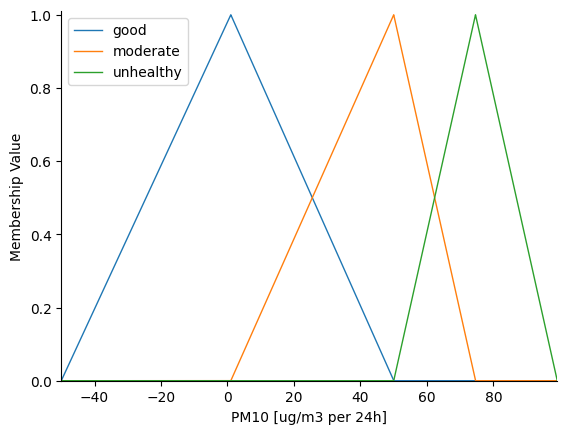

In [1507]:
pm10_list = [pm10_min, pm10_safe_limit, pm10_max]
pm10_list.sort()
print(pm10_list)

pm10 = ctrl.Antecedent(np.arange(-pm10_list[1], pm10_list[2] + (pm10_list[2] - pm10_list[1]) + step_size, step_size), "pm10")
pm10[good] = fuzz.trimf(pm10.universe, [-pm10_list[1], pm10_list[0], pm10_list[1]])
pm10[moderate] = fuzz.trimf(pm10.universe, [pm10_list[0], pm10_list[1], pm10_list[2]])
pm10[unhealthy] = fuzz.trimf(pm10.universe, [pm10_list[1], pm10_list[2], pm10_list[2] + (pm10_list[2] - pm10_list[1])])
pm10.view()

print(pm10_safe_limit, pm10_min, pm10_max, pm10_max)

plt.xlabel("PM10 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

[1.0, 25, 270.9]


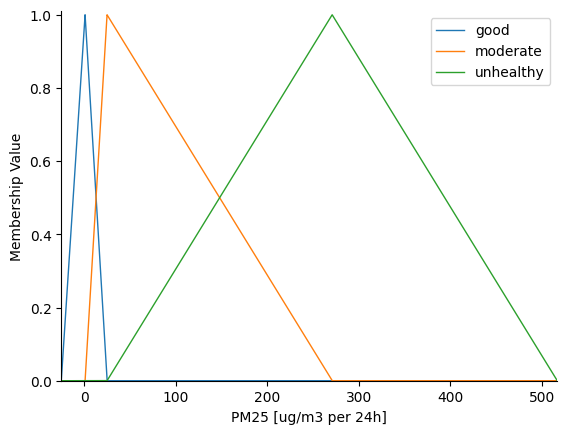

In [1508]:
pm25_list = [pm25_min, pm25_safe_limit, pm25_max]
pm25_list.sort()
print(pm25_list)

pm25 = ctrl.Antecedent(np.arange(-pm25_list[1], pm25_list[2] + (pm25_list[2] - pm25_list[1]) + step_size, step_size), "pm25")
pm25[good] = fuzz.trimf(pm25.universe, [-pm25_list[1], pm25_list[0], pm25_list[1]])
pm25[moderate] = fuzz.trimf(pm25.universe, [pm25_list[0], pm25_list[1], pm25_list[2]])
pm25[unhealthy] = fuzz.trimf(pm25.universe, [pm25_list[1], pm25_list[2], pm25_list[2] + (pm25_list[2] - pm25_list[1])])
pm25.view()

plt.xlabel("PM25 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [1509]:
air_quality_poor = 0
air_quality_bad = 25
air_quality_normal =  50
air_quality_good = 75
air_quality_excelent = 100

In [1510]:
pollution_minimal = 0
pollution_low = 25
pollution_normal = 50
pollution_high = 75
pollution_maximum = 100

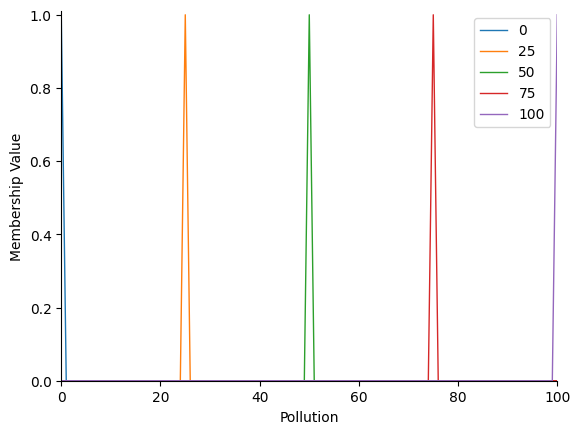

In [1511]:
pollution = ctrl.Consequent(np.arange(0, 101, 1), "pollution", defuzzify_method="centroid")
pollution[pollution_minimal] = fuzz.trimf(pollution.universe, [0, 0, 0])
pollution[pollution_low] = fuzz.trimf(pollution.universe, [25, 25, 25])
pollution[pollution_normal] = fuzz.trimf(pollution.universe, [50, 50, 50])
pollution[pollution_high] = fuzz.trimf(pollution.universe, [75, 75, 75])
pollution[pollution_maximum] = fuzz.trimf(pollution.universe, [100, 100, 100])
pollution.view()

plt.xlabel("Pollution")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [1512]:
rule1 = ctrl.Rule(pm10[unhealthy] & pm25[unhealthy],  pollution[pollution_maximum])

rule2 = ctrl.Rule(pm10[good] & pm25[unhealthy],  pollution[pollution_high])
rule3 = ctrl.Rule(pm10[moderate] & pm25[unhealthy],  pollution[pollution_maximum])
rule4 = ctrl.Rule(pm10[unhealthy] & pm25[good],  pollution[pollution_high])
rule5 = ctrl.Rule(pm10[unhealthy] & pm25[moderate],  pollution[pollution_maximum])

rule6 = ctrl.Rule(pm10[good] & pm25[good],  pollution[pollution_minimal])
rule7 = ctrl.Rule(pm10[good] & pm25[moderate],  pollution[pollution_low])
rule8 = ctrl.Rule(pm10[moderate] & pm25[good],  pollution[pollution_low])
rule9 = ctrl.Rule(pm10[moderate] & pm25[moderate],  pollution[pollution_normal])

In [1513]:
pollution_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
pollution_sim = ctrl.ControlSystemSimulation(pollution_ctrl)

In [1514]:
num_of_points = 100
pm10_values = np.linspace(0, pm10_max, num_of_points)
pm25_values = np.linspace(0, pm25_max, num_of_points)
pm10_mesh, pm25_mesh= np.meshgrid(pm10_values, pm25_values)
pollution_values = np.zeros_like(pm10_mesh)

In [1515]:
def compute(defuzzify_method):
    pollution.defuzzify_method = defuzzify_method
    for i in range(len(pm10_values)):
        for j in range(len(pm25_values)):
            pollution_sim.input["pm10"] = pm10_values[i]
            pollution_sim.input["pm25"] = pm25_values[j]
            pollution_sim.compute()
            pollution_values[i, j] = pollution_sim.output["pollution"]

In [1519]:
def display_3d_plot_pm_single(xlabel, ylabel, zlabel, azim):
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(pm10_mesh, pm25_mesh, pollution_values, cmap="RdYlGn_r")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    ax.view_init(azim=azim)

    plt.show()

def display_3d_plot_pm(ax, xlabel, ylabel, zlabel, azim):
    ax.plot_surface(pm10_mesh, pm25_mesh, pollution_values, cmap="RdYlGn_r")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.view_init(azim=azim)

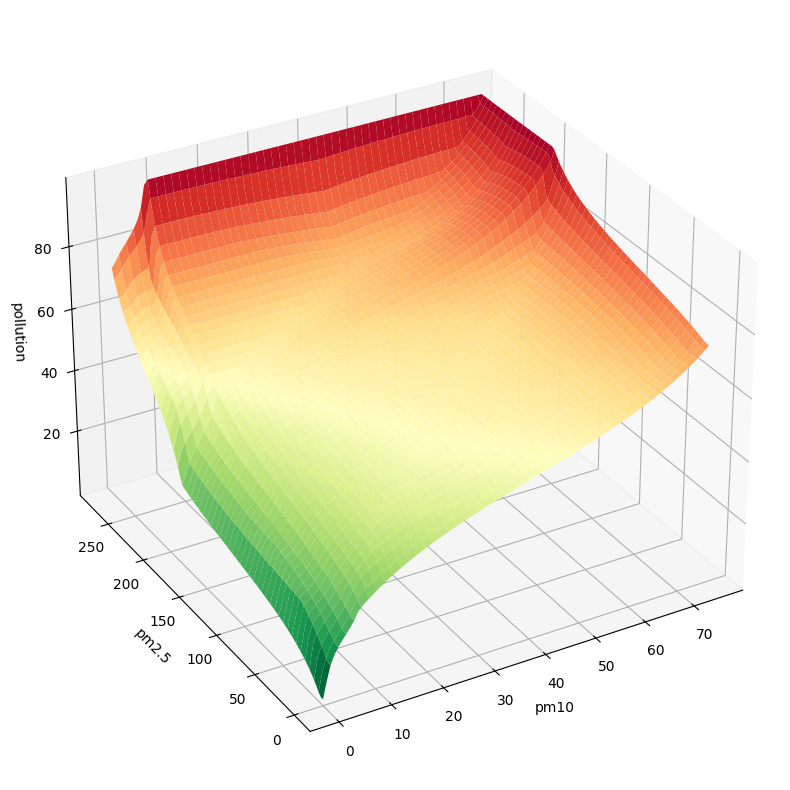

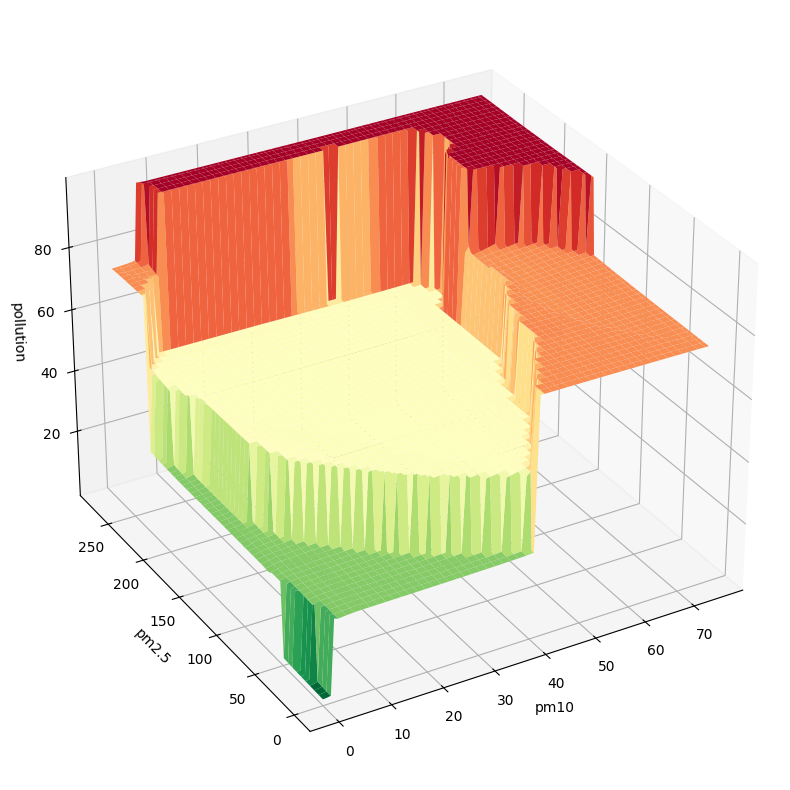

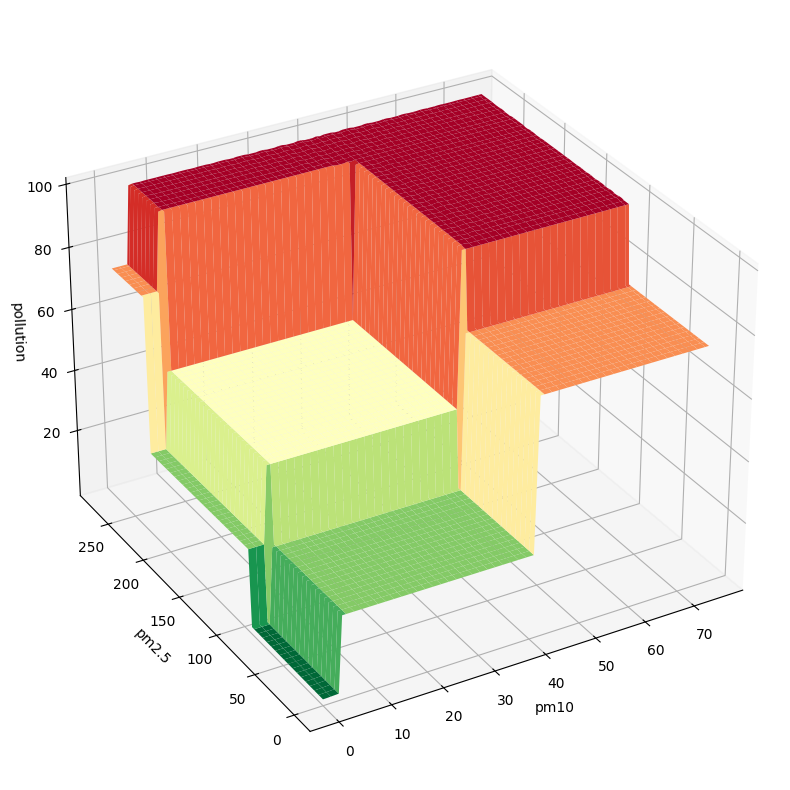

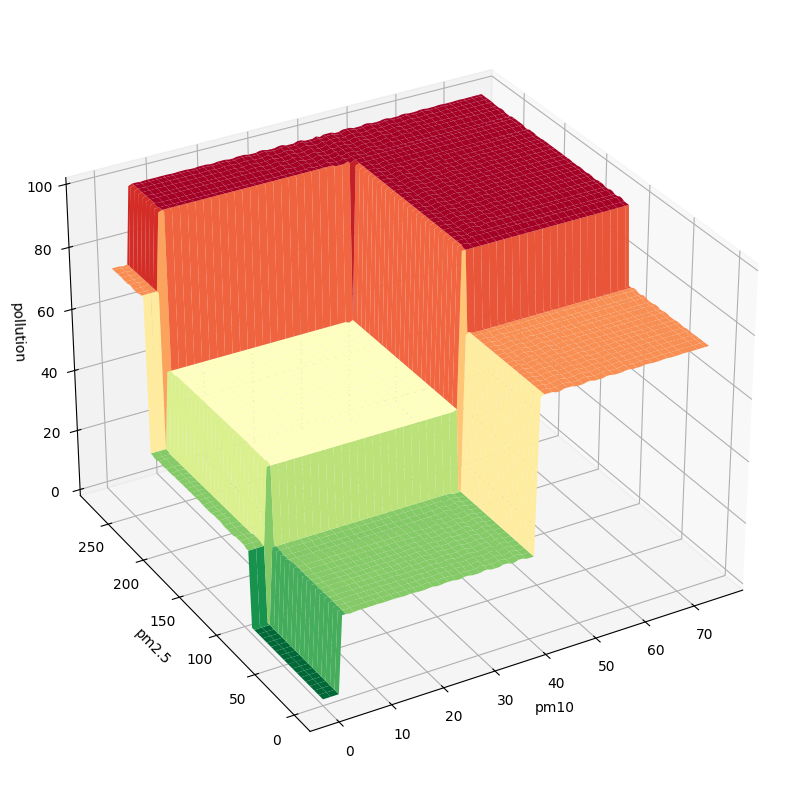

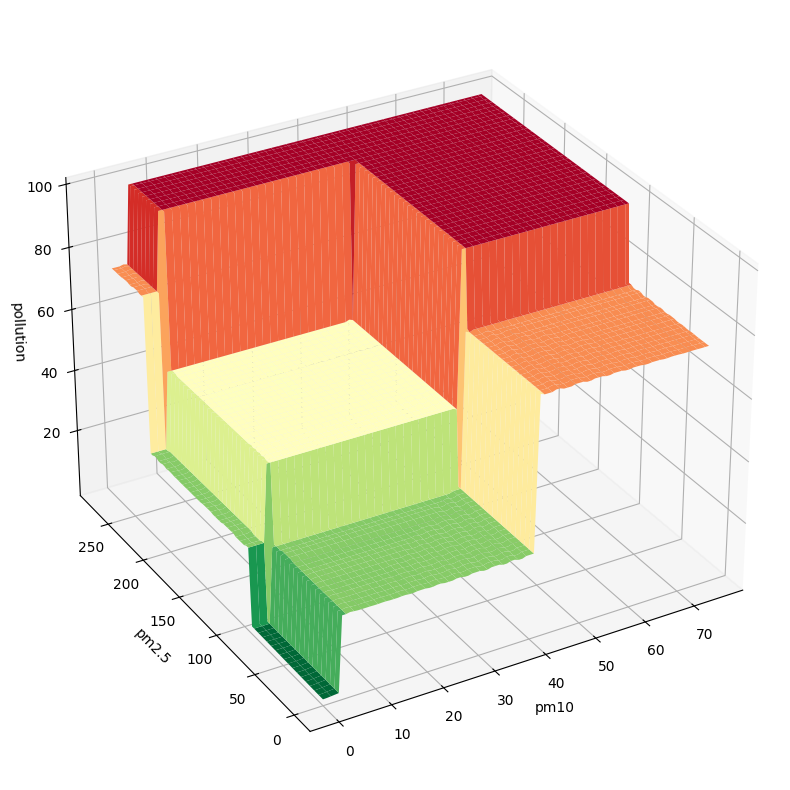

In [1522]:
compute("centroid")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution", -120)

compute("bisector")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("mom")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("som")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("lom")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

In [1518]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 15), subplot_kw={"projection": "3d"})
# methods = ["centroid", "bisector", "mom", "som", "lom"]

# for i, method in enumerate(methods):
#     row, col = divmod(i, 3)
#     ax = axs[row, col]
#     compute(method)
#     display_3d_plot_pm(ax, "pm10", "pm2.5", "pollution", 60)
# plt.tight_layout()

# plt.show()

INTERFERENCE SYSTEM II - pollution, wind -> air_quality